## 1. Training
My training contains the following steps:
1. Prepare a balanced data set to avoid classifier overfitting to one class.
1. Collect different features (color/gradient/HOG) from images.
1. Split data set to training set and testing set.
1. Normalise these features to avoid certain features dominating the classifier.
1. Train a linear SVM classifier to classify samples as cars or non-cars.

## 1.1 Prepare balanced training set and testing set to avoid classifier overfitting to one class

In [1]:
import cv2
import glob
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Divide up into cars and notcars
cars = glob.glob('vehicles/*/*.png')
not_cars = glob.glob('non-vehicles/*/*.png')

# Random pick one from each set to inspect
rand_ind = np.random.randint(0, len(cars))
rand_car_img = mpimg.imread(cars[rand_ind])
rand_ind = np.random.randint(0, len(not_cars))
rand_not_car_img = mpimg.imread(not_cars[rand_ind])

figure, axs = plt.subplots(1, 2)
axs[0].set_title('Sample of Car Image')
axs[0].imshow(rand_car_img)
axs[1].set_title('Sample of Non-Car Image')
axs[1].imshow(rand_not_car_img)

plt.figure()
plt.bar([0, 1], [len(cars), len(not_cars)])
plt.xticks([0, 1], ['Vehicles', 'Non-Vehicles'])

/home/cli/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


([<matplotlib.axis.XTick at 0x7f3ea8c0b748>,
 <a list of 2 Text xticklabel objects>)

The diagram suggests that we have roughtly the same number of vehicle images and non-vehicle images. Now let's split them into training set and testing set.

## 1.2 Collect different features (color/gradient/HOG) from images.

In [2]:
# Define a function to return HOG features and visualization
# Utility function from Udacity
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=False):     
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)        
        return features

# Define a function to extract features from a single image
# Modified Utility function from Udacity
def extract_image_features(image, cspace='RGB', orient=9, 
                           pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False, feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=vis, feature_vec=feature_vec))
        hog_features = np.ravel(hog_features)
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                        pix_per_cell, cell_per_block, vis=vis, feature_vec=feature_vec)
    
    return hog_features

# Define a function to extract features from a list of images
# Modified Utility function from Udacity
def extract_features(imgs, cspace='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0, feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        hog_features = extract_image_features(image, cspace=colorspace, orient=orient, 
                                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                              hog_channel=hog_channel, feature_vec=feature_vec)
        features.append(hog_features)
    # Return list of feature vectors
    return features

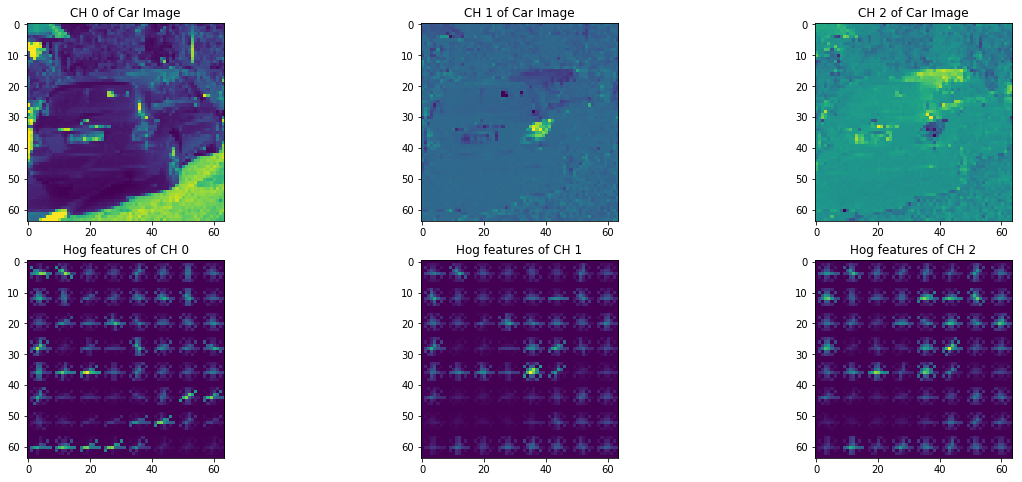

In [3]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rand_car_img_conv = cv2.cvtColor(rand_car_img, cv2.COLOR_RGB2YCrCb)

figure, axs = plt.subplots(2, 3, figsize=(20, 8))
   
for j in range(3):
    axs[0][j].set_title('CH {} of Car Image'.format(j))
    axs[0][j].imshow(rand_car_img_conv[:,:,j])
    
for j in range(3):    
    car_features = get_hog_features(rand_car_img_conv[:,:,j], orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            vis=True, feature_vec=False)
    axs[1][j].set_title('Hog features of CH {}'.format(j))
    axs[1][j].imshow(car_features[1])

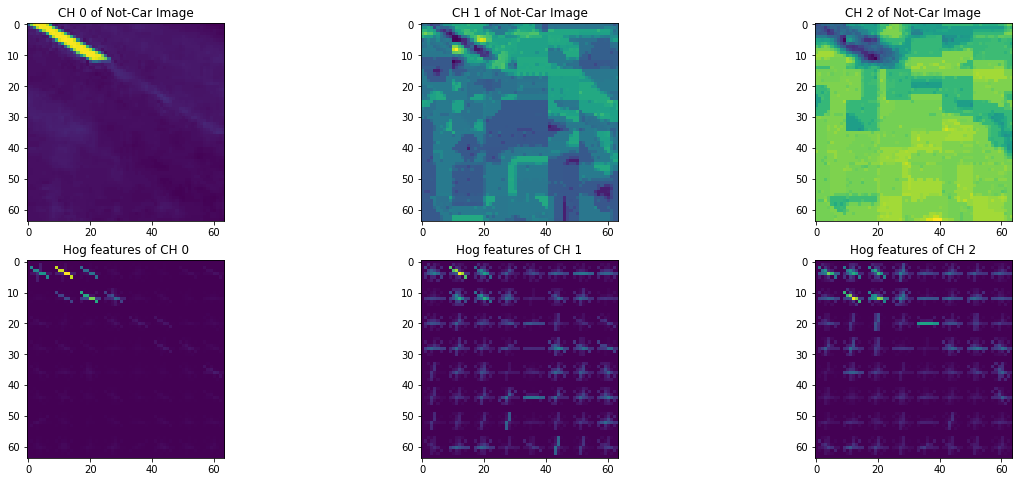

In [4]:
rand_not_car_img_conv = cv2.cvtColor(rand_not_car_img, cv2.COLOR_RGB2YCrCb)
figure, axs = plt.subplots(2, 3, figsize=(20, 8))
   
for j in range(3):
    axs[0][j].set_title('CH {} of Not-Car Image'.format(j))
    axs[0][j].imshow(rand_not_car_img_conv[:,:,j])
    
for j in range(3):    
    car_features = get_hog_features(rand_not_car_img_conv[:,:,j], orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            vis=True, feature_vec=False)
    axs[1][j].set_title('Hog features of CH {}'.format(j))
    axs[1][j].imshow(car_features[1])

102.16 Seconds to extract HOG features...


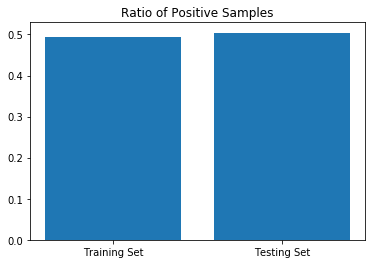

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
11.49 Seconds to train SVC...
Test Accuracy of SVC =  0.9786


In [5]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
notcar_features = extract_features(not_cars, cspace=colorspace, orient=orient, 
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=rand_state)

plt.title('Ratio of Positive Samples')
positives_train = np.count_nonzero(y_train) / len(y_train)
positives_test  = np.count_nonzero(y_test) / len(y_test)
plt.bar([0, 1], [positives_train, positives_test])
plt.xticks([0, 1], ['Training Set', 'Testing Set'])
plt.show()

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
      'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Now try to predict on some test images.

[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
0.00187 Seconds to predict 10 labels with SVC


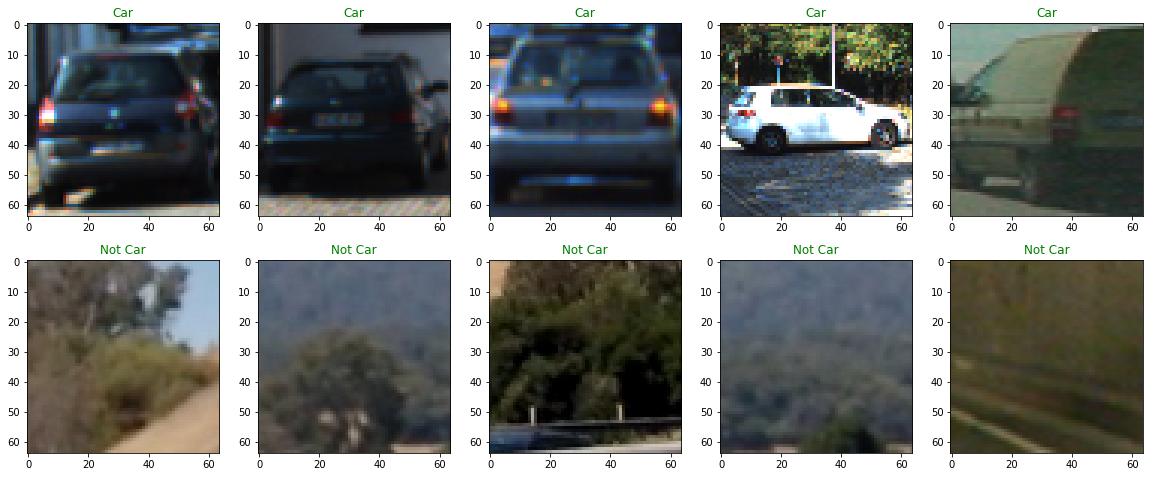

In [6]:
n_predict = 5

random_car_indices = (np.random.rand(n_predict) * len(cars)).astype(int)
random_cars = np.take(np.array(cars), random_car_indices)
random_not_car_indices = (np.random.rand(n_predict) * len(not_cars)).astype(int)
random_not_cars = np.take(np.array(not_cars), random_car_indices)

randoms = np.concatenate((random_cars, random_not_cars), axis=None)
random_features = extract_features(randoms, cspace=colorspace, orient=orient, 
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)
t=time.time()
X_random = np.vstack((random_features)).astype(np.float64)
X_random = X_scaler.transform(X_random)
y_test = np.concatenate((np.ones(n_predict), np.zeros(n_predict)), axis=None)
y_predict = svc.predict(X_random)
print(y_test)
print(y_predict)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict * 2,'labels with SVC')

fig, ax = plt.subplots(2, 5, figsize=(20, 8))

for i in range(n_predict * 2):
    subax = ax[int(i / n_predict)][int(i % n_predict)]
    color = 'g' if y_predict[i] == y_test[i] else 'r'    
    subax.set_title('{}'.format('Car' if y_predict[i] else 'Not Car'), color=color)
    subax.imshow(mpimg.imread(randoms[i]))    

plt.show()

## 2. Pipeline
1. Extract the ROI from image.
1. Resize ROI using different scales. We want to resize the top of ROI using a smaller scale as cars are further away.
1. Collect HOG features for the whole scaled image.
1. Normalise these features to avoid the dominance from certain sets of features.
1. Move a sliding window in the new image and classify if there is car in the current window. Window size is chosen to be the same as the training samples (64x64). `cells_per_step` of `2` is chosen to have a `75%` overlap between windows.
1. To reduce false positives, maintain a heatmap with the current frame and several previous frames. The final outout are the windows with a confidence above threshold.

0.58251 Seconds to predict one test image with SVC
0.59915 Seconds to predict one test image with SVC
0.58797 Seconds to predict one test image with SVC
0.63763 Seconds to predict one test image with SVC
0.58779 Seconds to predict one test image with SVC
0.58384 Seconds to predict one test image with SVC


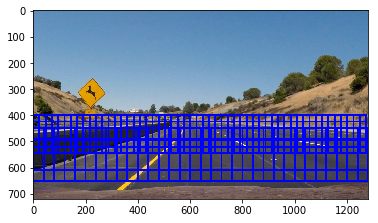

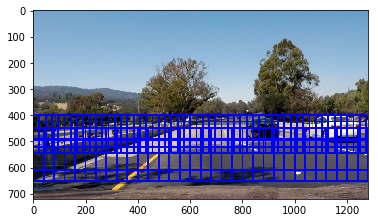

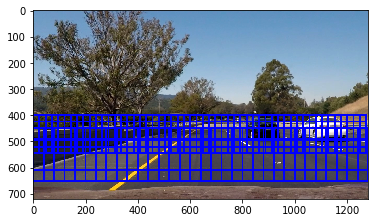

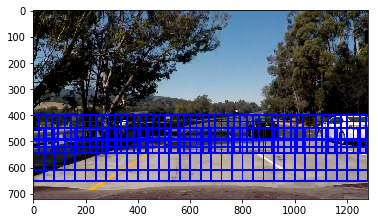

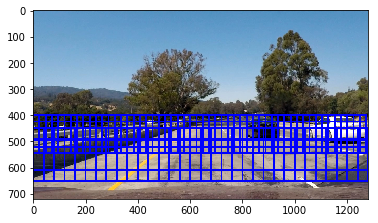

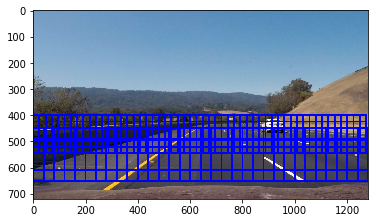

In [71]:
# Util function from Udacity
def convert_color(img, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)    
    return img

# Define a single function that can extract features using hog sub-sampling and make predictions
# Modified Util function from Udacity
def find_cars(img, hog_channel, cspace, ystart, ystop, scale, svc, \
              X_scaler, orient, pix_per_cell, cell_per_block, cells_per_step, \
              save_output=False, filename=''):    
    # jpg and video frames come in [0...255]
    img = img.astype(np.float32)/255
        
    img_tosearch = img[ystart:ystop,:,:]
        
    ctrans_tosearch = convert_color(img_tosearch, cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch_scale = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    else:
        ctrans_tosearch_scale = ctrans_tosearch

    ch1 = ctrans_tosearch_scale[:,:,0]
    ch2 = ctrans_tosearch_scale[:,:,1]
    ch3 = ctrans_tosearch_scale[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    # Instead of overlap, use how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 0 or hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 1 or hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 2 or hog_channel == 'ALL':
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bbox_list = []    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 0 or hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 1 or hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 2 or hog_channel == 'ALL':
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                
            if hog_channel == 0:
                hog_features = np.hstack((hog_feat1))
            if hog_channel == 1:
                hog_features = np.hstack((hog_feat2))
            if hog_channel == 2:
                hog_features = np.hstack((hog_feat3))
            if hog_channel == 'ALL':
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch_scale[ytop:ytop+window, xleft:xleft+window], (64,64))

            # TODO: Only use hog features for now
            # Get color features            
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            # TODO: Only use hog features for now
            #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))
            # np.hstack() is horribally slow
            test_features = X_scaler.transform(hog_features.reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
                        
            if test_prediction == 1 or save_output:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = [(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)]                
                bbox_list.append(bbox)

    if save_output:
        cv2.imwrite('output_images/roi/' + filename, cv2.cvtColor(img_tosearch * 255, cv2.COLOR_BGR2RGB))
        cv2.imwrite('output_images/ctrans_ch0/' + filename, ctrans_tosearch[:,:,0] * 255)
        cv2.imwrite('output_images/resize/' + filename, ctrans_tosearch_scale[:,:,0] * 255)
        hog1_vis = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=True)
        cv2.imwrite('output_images/hog/' + filename, hog1_vis[1] * 255)        
    return bbox_list
        
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from collections import deque
from scipy.ndimage.measurements import label

class VehicleDetector():
    def __init__(self):        
        self.bbox_lists = deque()
        
    def process(self, img, use_heat_map=False, save_output=False, filename=''):
        # First scale        
        ystart = 400
        ystop = 550
        scale = 1.5
        cells_per_step = 2
        bbox_list_1 = find_cars(img, hog_channel, colorspace, ystart, ystop, scale, svc, \
                                X_scaler, orient, pix_per_cell, cell_per_block, cells_per_step, save_output, filename)
        # Second scale
        ystart = 450
        ystop = 650
        scale = 2.5
        cells_per_step = 2
        bbox_list_2 = find_cars(out_img, hog_channel, colorspace, ystart, ystop, scale, svc, \
                                X_scaler, orient, pix_per_cell, cell_per_block, cells_per_step, save_output, filename)
        
        bbox_list = bbox_list_1 + bbox_list_2
        if use_heat_map:
            if len(self.bbox_lists) > 5:
                self.bbox_lists.popleft()
            self.bbox_lists.append(bbox_list)
            
            heat_map = np.zeros_like(out_img)
            for bbox_list in self.bbox_lists:
                add_heat(heat_map, bbox_list)
            heat_map = apply_threshold(heat_map, 2)            
            # Visualise heatmap
            #heatmap = np.clip(heat, 0, 255)
            # Find final boxes from heatmap using label function
            labels = label(heat_map)
            #print(labels[1], 'cars found')
            #plt.imshow(labels[0], cmap='gray')
            draw_img = np.copy(img)
            draw_img = draw_labeled_bboxes(draw_img, labels)
        else:
            draw_img = np.copy(img)
            for bbox in bbox_list:                
                cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
        
        if save_output:
            cv2.imwrite('output_images/windows/' + filename, draw_img)
        return draw_img        
        
detector = VehicleDetector()

output_dirs = ['output_images/roi', 'output_images/ctrans_ch0', 'output_images/resize', 'output_images/hog', 'output_images/windows']
for output_dir in output_dirs:
    try:
        os.mkdir(output_dir)
    except:
        pass

test_images = glob.glob('test_images/*.jpg')
for test_image in test_images:
    img = mpimg.imread(test_image)
    filename = os.path.basename(test_image)

    t=time.time()
    
    out_img = detector.process(img, save_output=True, filename=filename)
    
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict one test image with SVC')
    
    plt.figure()
    plt.imshow(out_img)

Now try to predict on test images.

0.18593 Seconds to predict one test image with SVC
0.18963 Seconds to predict one test image with SVC
0.19419 Seconds to predict one test image with SVC
0.17842 Seconds to predict one test image with SVC
0.18104 Seconds to predict one test image with SVC
0.18635 Seconds to predict one test image with SVC


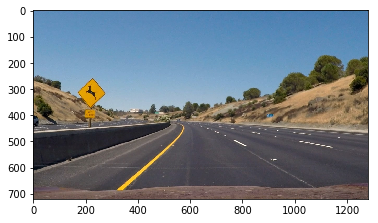

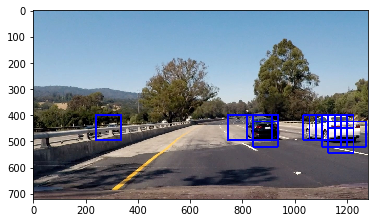

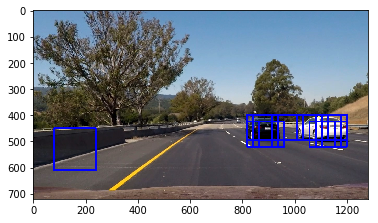

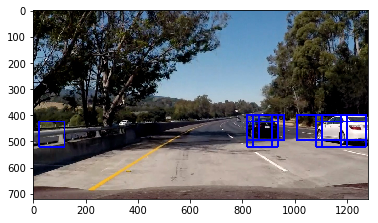

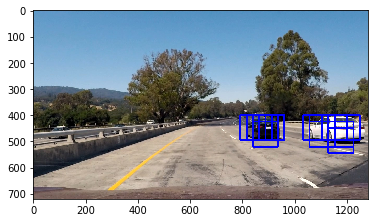

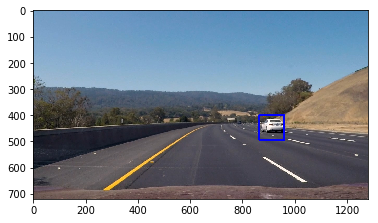

In [61]:
test_images = glob.glob('test_images/*.jpg')
for test_image in test_images:
    img = mpimg.imread(test_image)
    filename = os.path.basename(test_image)
    t=time.time()    
    
    out_img = detector.process(img)
    
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict one test image with SVC')
    
    plt.figure()
    plt.imshow(out_img)

In [72]:
detector = VehicleDetector()

def pipeline_video(img):    
    out_img = detector.process(img, use_heat_map=True)    
    return out_img

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

try:
    os.mkdir("output_videos")
except:
    pass

index = 0

def process_image(img):    
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes) 
    global index
    index += 1    
    img = pipeline_video(img)    
    return img

video_output = 'output_videos/test_video.mp4'
clip = VideoFileClip("test_video.mp4")
clip_processed = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time clip_processed.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|█████████▋| 38/39 [00:10<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

CPU times: user 40.9 s, sys: 705 ms, total: 41.6 s
Wall time: 10.8 s


In [ ]:
video_output = 'output_videos/project_video.mp4'
clip = VideoFileClip("project_video.mp4")
clip_processed = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time clip_processed.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 89%|████████▉ | 1125/1261 [05:23<00:39,  3.47it/s]